# **Build a Dataset Class for Horse Breeds**

https://www.kaggle.com/datasets/olgabelitskaya/horse-breeds

In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("olgabelitskaya/horse-breeds")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'horse-breeds' dataset.
Path to dataset files: /kaggle/input/horse-breeds


### Import Libraries & Path Setup

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob, os, torch
import torch.nn as nn
import torch.optim as optim
import kagglehub
from PIL import Image
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms, models
from sklearn.model_selection import train_test_split
from collections import Counter

# Download dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cpu


### Data Preparation (Stratified Split)

In [34]:
all_images = []
for ext in ('/**/*.jpg', '/**/*.jpeg', '/**/*.JPG', '/**/*.png'):
    all_images.extend(glob.glob(path + ext, recursive=True))

data = [(img, os.path.basename(img).split('_')[0]) for img in all_images]
df = pd.DataFrame(data, columns=['filepath', 'label'])
label_to_idx = {label: i for i, label in enumerate(df['label'].unique())}
df['label_idx'] = df['label'].map(label_to_idx)

train_df, temp_df = train_test_split(df, test_size=0.20, stratify=df['label_idx'], random_state=42)
val_df, test_df = train_test_split(temp_df, test_size=0.50, stratify=temp_df['label_idx'], random_state=42)

### Dataset Class

In [35]:
class HorseBreedDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
    def __len__(self):
        return len(self.dataframe)
    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx]['filepath']
        label = self.dataframe.iloc[idx]['label_idx']
        image = Image.open(img_path).convert("RGB")
        if self.transform: image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

### Transforms (Data Augmentation Included)

In [36]:
my_mean, my_std = [0.485, 0.456, 0.406], [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(my_mean, my_std)
])

test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(my_mean, my_std)
])

### DataLoaders (Imbalance Handling)

In [37]:
class_counts = Counter(train_df['label_idx'])
weights = 1. / torch.tensor([class_counts[i] for i in range(len(label_to_idx))], dtype=torch.float)
samples_weights = weights[train_df['label_idx'].values]
sampler = WeightedRandomSampler(weights=samples_weights, num_samples=len(samples_weights), replacement=True)

train_loader = DataLoader(HorseBreedDataset(train_df, train_transforms), batch_size=32, sampler=sampler)
val_loader = DataLoader(HorseBreedDataset(val_df, test_transforms), batch_size=32, shuffle=False)
test_loader = DataLoader(HorseBreedDataset(test_df, test_transforms), batch_size=32, shuffle=False)

### Model, Loss, and Optimizer

In [38]:
def get_model(num_classes):
    model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
    for param in model.parameters(): param.requires_grad = False # Freeze backbone
    model.fc = nn.Sequential(
        nn.Linear(model.fc.in_features, 256),
        nn.ReLU(),
        nn.Dropout(0.3),
        nn.Linear(256, num_classes)
    )
    return model

model = get_model(len(label_to_idx)).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.001)

### Display Sample Images

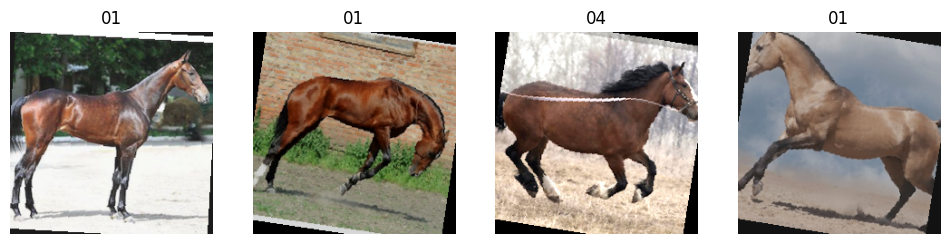

In [41]:
def show_batch(loader, labels_map):
    images, labels = next(iter(loader))
    plt.figure(figsize=(12, 6))
    for i in range(4):
        plt.subplot(1, 4, i+1)
        img = images[i].permute(1, 2, 0).numpy() * my_std + my_mean
        plt.imshow(np.clip(img, 0, 1))
        plt.title(list(labels_map.keys())[labels[i]])
        plt.axis('off')
    plt.show()

show_batch(train_loader, label_to_idx)

### Training Loop (With Best Model Saving)

In [40]:
def train_model(model, train_loader, val_loader, criterion, optimizer, epochs=10):
    history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}
    best_acc = 0.0

    for epoch in range(epochs):
        # Training Phase
        model.train()
        t_loss, t_corr = 0, 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            t_loss += loss.item() * inputs.size(0)
            t_corr += torch.sum(torch.max(outputs, 1)[1] == labels.data)
        
        # Validation Phase
        model.eval()
        v_loss, v_corr = 0, 0
        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                v_loss += loss.item() * inputs.size(0)
                v_corr += torch.sum(torch.max(outputs, 1)[1] == labels.data)

        # Calculate & Store Metrics
        train_loss = t_loss / len(train_loader.dataset)
        val_loss = v_loss / len(val_loader.dataset)
        train_acc = t_corr.double() / len(train_loader.dataset)
        val_acc = v_corr.double() / len(val_loader.dataset)
        
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_acc'].append(train_acc.item()) # FIXED: Added train_acc
        history['val_acc'].append(val_acc.item())
        
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(model.state_dict(), 'best_horse_model.pth')
            
        print(f'Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f} | Val Acc: {val_acc:.4f}')
    return history

history = train_model(model, train_loader, val_loader, criterion, optimizer, epochs=15)

Epoch 1/15 | Train Loss: 1.7097 | Val Acc: 0.6866
Epoch 2/15 | Train Loss: 1.1980 | Val Acc: 0.8358
Epoch 3/15 | Train Loss: 0.9814 | Val Acc: 0.7910
Epoch 4/15 | Train Loss: 0.8459 | Val Acc: 0.8657
Epoch 5/15 | Train Loss: 0.7100 | Val Acc: 0.8955
Epoch 6/15 | Train Loss: 0.6390 | Val Acc: 0.8507
Epoch 7/15 | Train Loss: 0.6121 | Val Acc: 0.8209
Epoch 8/15 | Train Loss: 0.5496 | Val Acc: 0.8955
Epoch 9/15 | Train Loss: 0.6570 | Val Acc: 0.8955
Epoch 10/15 | Train Loss: 0.4644 | Val Acc: 0.8955
Epoch 11/15 | Train Loss: 0.4492 | Val Acc: 0.9104
Epoch 12/15 | Train Loss: 0.4112 | Val Acc: 0.9104
Epoch 13/15 | Train Loss: 0.4105 | Val Acc: 0.8955
Epoch 14/15 | Train Loss: 0.3861 | Val Acc: 0.9104
Epoch 15/15 | Train Loss: 0.3954 | Val Acc: 0.8955


### Plot Results, Test & Analyze

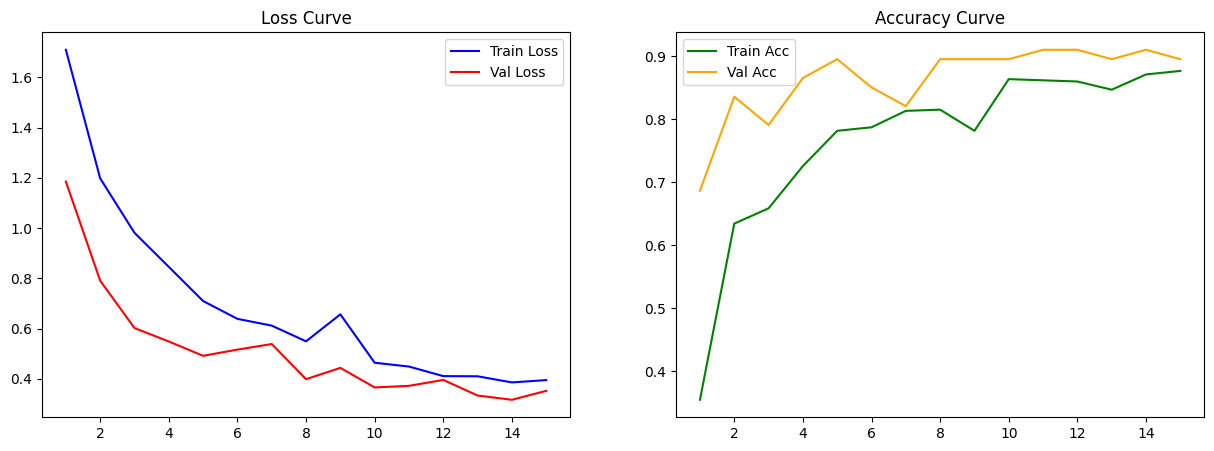

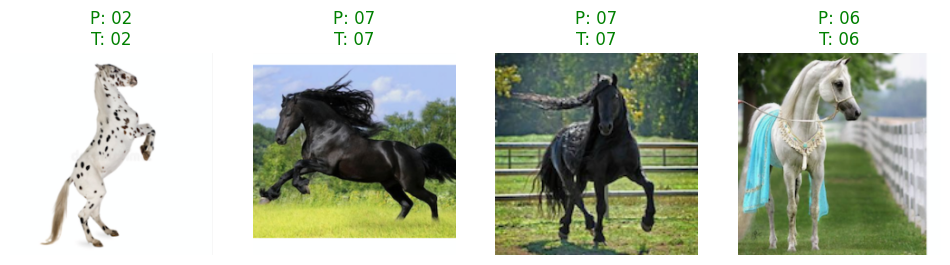

In [42]:
def plot_results(history):
    epochs = range(1, len(history['train_loss']) + 1)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
    
    ax1.plot(epochs, history['train_loss'], 'b', label='Train Loss')
    ax1.plot(epochs, history['val_loss'], 'r', label='Val Loss')
    ax1.set_title('Loss Curve'); ax1.legend()
    
    ax2.plot(epochs, history['train_acc'], 'g', label='Train Acc')
    ax2.plot(epochs, history['val_acc'], 'orange', label='Val Acc')
    ax2.set_title('Accuracy Curve'); ax2.legend()
    plt.show()

def predict_and_plot(model, loader, class_names):
    model.load_state_dict(torch.load('best_horse_model.pth'))
    model.eval()
    images, labels = next(iter(loader))
    with torch.no_grad():
        outputs = model(images.to(device))
        preds = torch.max(outputs, 1)[1]
    
    plt.figure(figsize=(12, 8))
    for i in range(min(4, len(images))):
        plt.subplot(1, 4, i+1)
        img = images[i].permute(1, 2, 0).numpy() * my_std + my_mean
        plt.imshow(np.clip(img, 0, 1))
        color = 'green' if preds[i] == labels[i] else 'red'
        plt.title(f"P: {class_names[preds[i].item()]}\nT: {class_names[labels[i].item()]}", color=color)
        plt.axis('off')
    plt.show()

plot_results(history)
predict_and_plot(model, test_loader, list(label_to_idx.keys()))

### Final Load & Save Check

In [43]:
# Final evaluation on the hidden test set
model.load_state_dict(torch.load('best_horse_model.pth'))
model.eval()
correct, total = 0, 0
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        correct += torch.sum(torch.max(outputs, 1)[1] == labels.data)
        total += labels.size(0)
print(f'Test Accuracy of the Best Saved Model: {100 * correct / total:.2f}%')

Test Accuracy of the Best Saved Model: 82.09%
